In [1]:
import os
os.chdir('D:\\Gnan\\DA\\KMU\\Prediction-COVID-19')
from utils import *
from model import *
from trainer import *

from torch.optim.adam import Adam
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
path = 'Data/SIR_Origin/*.csv'
dic_files = Load_files.load_files(path, -17, -15)
data = dic_files['서울']
data

,Date,City,Susceptible,Infected,Dead,Recovered,alpha,beta,gamma
0,2020-01-20,서울,9535432,0,0,0,0.000000,0.000000,0.000000
1,2020-01-21,서울,9535432,0,0,0,0.000000,0.000000,0.000000
2,2020-01-22,서울,9535432,0,0,0,0.000000,0.000000,0.000000
3,2020-01-23,서울,9535432,0,0,0,0.000000,0.000000,0.000000
4,2020-01-24,서울,9535431,1,0,0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
1214,2023-05-20,서울,3372946,63591,6471,6092424,0.186540,0.169175,0.000031
1215,2023-05-21,서울,3368750,57027,6473,6103182,0.063087,0.028793,0.000053
1216,2023-05-22,서울,3367479,56653,6476,6104824,0.268003,0.101407,0.000018
1217,2023-05-23,서울,3362117,56269,6477,6110569,0.267742,0.099895,0.000036


In [3]:
learning_rates_list = [1e-3, 1e-4, 1e-5]
patiences_list = [20, 50, 100]
num_layers_list = [2, 4, 8]
batch_sizes_list = [16, 32, 64]
hidden_sizes_list = [8, 16, 32]
dropout_list = [0.25, 0.5]

hyperparameter_dict = {}
i = 0

for lr in learning_rates_list:
    for patience in patiences_list:
        for num_layers in num_layers_list:
            for batch_sizes in batch_sizes_list:
                for hidden_size in hidden_sizes_list:    
                    for dropout in dropout_list:
                        hyperparameter_dict[i] = [lr, patience, num_layers, batch_sizes, hidden_size, dropout]
                        i += 1
                        
print(i)

486


In [4]:
criterion = nn.MSELoss()

input_size = 3
sequence_length = 60
num_epochs = 10000

df = Prepare_df.processing(data, 'Date', 'alpha')

x = df.iloc[:, 0:]
y = df.iloc[:,:1]

ms = MinMaxScaler()
ss = StandardScaler()

ss.fit(x)
ms.fit(y)

mape_min = np.inf
best_model = {}

for hyperparameter in hyperparameter_dict.values():
    lr = hyperparameter[0]
    patience = hyperparameter[1]
    num_layers = hyperparameter[2]
    batch_size = hyperparameter[3]
    hidden_size = hyperparameter[4]
    dropout = hyperparameter[5]
    print('-------------------------------------------------------------------------------------')
    print('lr:', lr, ' patience:', patience, ' num_layers:', num_layers, 
          ' batch_size:', batch_size, ' hidden_size:', hidden_size, ' dropout:', dropout)
    
    x, y, x_ss, y_ms, train_loader, test_loader = Prepare_df.split_data(df, 800, 60, 1, batch_size, 'mto')
    

    model = RNN(input_size = input_size,
                hidden_size = hidden_size,
                sequence_length = sequence_length,
                num_layers = num_layers, 
                dropout = dropout, 
                device = device).to(device)

    optimizer = Adam(model.parameters(), lr = lr)
    
    loss_list, model, epoch = Trainer.Many_to_One(train_loader, 
                                                  test_loader, 
                                                  model, 
                                                  criterion, 
                                                  optimizer, 
                                                  num_epochs, 
                                                  patience,
                                                  device)
    
    label_y, predicted = predict_mto(model, df, x_ss, y_ms)
    
    if mape_min > mape(label_y+1, predicted):
        mape_min = mape(label_y+1, predicted)
        best_model['RNN'] = [mape_min, model.state_dict(), epoch, lr, patience, num_layers, batch_size, hidden_size, dropout]

-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 8  dropout: 0.25

 Early Stopping / epoch: 61 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 8  dropout: 0.5

 Early Stopping / epoch: 61 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 16  dropout: 0.25

 Early Stopping / epoch: 81 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 16  dropout: 0.5

 Early Stopping / epoch: 81 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 16  hi


 Early Stopping / epoch: 61 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 16  dropout: 0.25

 Early Stopping / epoch: 41 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 16  dropout: 0.5

 Early Stopping / epoch: 81 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 32  dropout: 0.25

 Early Stopping / epoch: 81 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 32  dropout: 0.5

 Early Stopping / epoch: 61 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  pat


 Early Stopping / epoch: 151 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 8  dropout: 0.5
epoch: 100 loss: 0.0002
epoch: 200 loss: 0.0000
epoch: 300 loss: 0.0001

 Early Stopping / epoch: 301 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 16  dropout: 0.25
epoch: 100 loss: 0.0001

 Early Stopping / epoch: 101 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 16  dropout: 0.5
epoch: 100 loss: 0.0003

 Early Stopping / epoch: 151 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.25
epoch: 100 loss: 0.

epoch: 1900 loss: 0.0007
epoch: 2000 loss: 0.0007
epoch: 2100 loss: 0.0007

 Early Stopping / epoch: 2101 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.25
epoch: 100 loss: 0.0007
epoch: 200 loss: 0.0001
epoch: 300 loss: 0.0000
epoch: 400 loss: 0.0000

 Early Stopping / epoch: 401 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.5
epoch: 100 loss: 0.0007
epoch: 200 loss: 0.0007

 Early Stopping / epoch: 201 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.25
epoch: 100 loss: 0.0007

 Early Stopping / epoch: 101 loss: 0.0007
--------------------------------------------------------------------

epoch: 200 loss: 0.0002

 Early Stopping / epoch: 201 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.5
epoch: 100 loss: 0.0001
epoch: 200 loss: 0.0001
epoch: 300 loss: 0.0000

 Early Stopping / epoch: 301 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25
epoch: 100 loss: 0.0001
epoch: 200 loss: 0.0000
epoch: 300 loss: 0.0000
epoch: 400 loss: 0.0000

 Early Stopping / epoch: 401 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5
epoch: 100 loss: 0.0001
epoch: 200 loss: 0.0001
epoch: 300 loss: 0.0000
epoch: 400 loss: 0.0000

 Early Stopping / epoch: 401 loss: 0.0001
----------------------

epoch: 2100 loss: 0.0007
epoch: 2200 loss: 0.0007
epoch: 2300 loss: 0.0007
epoch: 2400 loss: 0.0007
epoch: 2500 loss: 0.0007
epoch: 2600 loss: 0.0007
epoch: 2700 loss: 0.0007
epoch: 2800 loss: 0.0007
epoch: 2900 loss: 0.0007
epoch: 3000 loss: 0.0007
epoch: 3100 loss: 0.0007
epoch: 3200 loss: 0.0007
epoch: 3300 loss: 0.0007
epoch: 3400 loss: 0.0007
epoch: 3500 loss: 0.0007
epoch: 3600 loss: 0.0007
epoch: 3700 loss: 0.0007
epoch: 3800 loss: 0.0007
epoch: 3900 loss: 0.0007
epoch: 4000 loss: 0.0007
epoch: 4100 loss: 0.0007
epoch: 4200 loss: 0.0007
epoch: 4300 loss: 0.0007

 Early Stopping / epoch: 4301 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.25
epoch: 100 loss: 0.0001
epoch: 200 loss: 0.0006

 Early Stopping / epoch: 201 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_

epoch: 100 loss: 0.0000

 Early Stopping / epoch: 101 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.5

 Early Stopping / epoch: 81 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25
epoch: 100 loss: 0.0007
epoch: 200 loss: 0.0002
epoch: 300 loss: 0.0001
epoch: 400 loss: 0.0001

 Early Stopping / epoch: 401 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5
epoch: 100 loss: 0.0007
epoch: 200 loss: 0.0004

 Early Stopping / epoch: 241 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  


 Early Stopping / epoch: 251 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 16  hidden_size: 16  dropout: 0.5
epoch: 100 loss: 0.0001
epoch: 200 loss: 0.0000

 Early Stopping / epoch: 251 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 16  hidden_size: 32  dropout: 0.25
epoch: 100 loss: 0.0000
epoch: 200 loss: 0.0000

 Early Stopping / epoch: 201 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 16  hidden_size: 32  dropout: 0.5
epoch: 100 loss: 0.0001
epoch: 200 loss: 0.0001

 Early Stopping / epoch: 201 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropo

epoch: 100 loss: 0.0007
epoch: 200 loss: 0.0007
epoch: 300 loss: 0.0005
epoch: 400 loss: 0.0002

 Early Stopping / epoch: 401 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25
epoch: 100 loss: 0.0001
epoch: 200 loss: 0.0001
epoch: 300 loss: 0.0000
epoch: 400 loss: 0.0000

 Early Stopping / epoch: 451 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5
epoch: 100 loss: 0.0006
epoch: 200 loss: 0.0002
epoch: 300 loss: 0.0001
epoch: 400 loss: 0.0001

 Early Stopping / epoch: 451 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25
epoch: 100 loss: 0.0001
epoch: 200 loss: 0.0000
epoch: 300 los

epoch: 100 loss: 0.0000
epoch: 200 loss: 0.0000
epoch: 300 loss: 0.0000

 Early Stopping / epoch: 301 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25
epoch: 100 loss: 0.0001
epoch: 200 loss: 0.0000
epoch: 300 loss: 0.0000
epoch: 400 loss: 0.0000
epoch: 500 loss: 0.0000
epoch: 600 loss: 0.0000
epoch: 700 loss: 0.0000

 Early Stopping / epoch: 701 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5
epoch: 100 loss: 0.0003
epoch: 200 loss: 0.0001
epoch: 300 loss: 0.0001
epoch: 400 loss: 0.0000
epoch: 500 loss: 0.0000
epoch: 600 loss: 0.0000

 Early Stopping / epoch: 601 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 2  batch_size: 

epoch: 100 loss: 0.0000
epoch: 200 loss: 0.0000

 Early Stopping / epoch: 201 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5
epoch: 100 loss: 0.0001
epoch: 200 loss: 0.0001
epoch: 300 loss: 0.0000
epoch: 400 loss: 0.0000
epoch: 500 loss: 0.0000
epoch: 600 loss: 0.0000

 Early Stopping / epoch: 601 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25
epoch: 100 loss: 0.0004
epoch: 200 loss: 0.0001
epoch: 300 loss: 0.0001
epoch: 400 loss: 0.0000
epoch: 500 loss: 0.0000
epoch: 600 loss: 0.0000
epoch: 700 loss: 0.0000

 Early Stopping / epoch: 701 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 4  batch_size: 64  hidden_size: 8  dro

epoch: 100 loss: 0.0003
epoch: 200 loss: 0.0001
epoch: 300 loss: 0.0001
epoch: 400 loss: 0.0000
epoch: 500 loss: 0.0000
epoch: 600 loss: 0.0000
epoch: 700 loss: 0.0000

 Early Stopping / epoch: 701 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.5
epoch: 100 loss: 0.0007
epoch: 200 loss: 0.0007
epoch: 300 loss: 0.0003
epoch: 400 loss: 0.0003

 Early Stopping / epoch: 401 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 8  dropout: 0.25
epoch: 100 loss: 0.0005
epoch: 200 loss: 0.0003
epoch: 300 loss: 0.0001
epoch: 400 loss: 0.0001

 Early Stopping / epoch: 401 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 8  dropout


 Early Stopping / epoch: 61 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5
epoch: 100 loss: 0.0009
epoch: 200 loss: 0.0008

 Early Stopping / epoch: 201 loss: 0.0009
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25
epoch: 100 loss: 0.0007

 Early Stopping / epoch: 121 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5

 Early Stopping / epoch: 81 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25
epoch: 100 loss: 0.0006

 Early Stopping / epoch: 181 loss: 0.0005
--

epoch: 100 loss: 0.0005
epoch: 200 loss: 0.0003
epoch: 300 loss: 0.0001
epoch: 400 loss: 0.0001
epoch: 500 loss: 0.0001
epoch: 600 loss: 0.0000

 Early Stopping / epoch: 601 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5
epoch: 100 loss: 0.0007
epoch: 200 loss: 0.0006
epoch: 300 loss: 0.0005

 Early Stopping / epoch: 351 loss: 0.0005
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25
epoch: 100 loss: 0.0004
epoch: 200 loss: 0.0002
epoch: 300 loss: 0.0001
epoch: 400 loss: 0.0000
epoch: 500 loss: 0.0000
epoch: 600 loss: 0.0000
epoch: 700 loss: 0.0000

 Early Stopping / epoch: 751 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  

epoch: 100 loss: 0.0007
epoch: 200 loss: 0.0007

 Early Stopping / epoch: 201 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 16  hidden_size: 8  dropout: 0.25
epoch: 100 loss: 0.0007
epoch: 200 loss: 0.0007

 Early Stopping / epoch: 251 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 16  hidden_size: 8  dropout: 0.5
epoch: 100 loss: 0.0008
epoch: 200 loss: 0.0007

 Early Stopping / epoch: 251 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 16  hidden_size: 16  dropout: 0.25
epoch: 100 loss: 0.0007

 Early Stopping / epoch: 151 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 16  hi

epoch: 400 loss: 0.0001
epoch: 500 loss: 0.0000
epoch: 600 loss: 0.0000
epoch: 700 loss: 0.0000
epoch: 800 loss: 0.0000
epoch: 900 loss: 0.0000
epoch: 1000 loss: 0.0000
epoch: 1100 loss: 0.0000

 Early Stopping / epoch: 1101 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25
epoch: 100 loss: 0.0006
epoch: 200 loss: 0.0004
epoch: 300 loss: 0.0004
epoch: 400 loss: 0.0002
epoch: 500 loss: 0.0001
epoch: 600 loss: 0.0001
epoch: 700 loss: 0.0001
epoch: 800 loss: 0.0001
epoch: 900 loss: 0.0000
epoch: 1000 loss: 0.0000

 Early Stopping / epoch: 1001 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5
epoch: 100 loss: 0.0007
epoch: 200 loss: 0.0007
epoch: 300 loss: 0.0006
epoch: 400 loss: 0.0006
epoch: 500 loss: 0.0006
epoch: 600 l

epoch: 100 loss: 0.0007
epoch: 200 loss: 0.0007
epoch: 300 loss: 0.0007
epoch: 400 loss: 0.0007
epoch: 500 loss: 0.0006
epoch: 600 loss: 0.0005
epoch: 700 loss: 0.0003
epoch: 800 loss: 0.0002
epoch: 900 loss: 0.0002
epoch: 1000 loss: 0.0002
epoch: 1100 loss: 0.0001

 Early Stopping / epoch: 1101 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.25
epoch: 100 loss: 0.0006
epoch: 200 loss: 0.0003
epoch: 300 loss: 0.0001
epoch: 400 loss: 0.0001
epoch: 500 loss: 0.0000
epoch: 600 loss: 0.0000
epoch: 700 loss: 0.0000
epoch: 800 loss: 0.0000
epoch: 900 loss: 0.0000
epoch: 1000 loss: 0.0000
epoch: 1100 loss: 0.0000
epoch: 1200 loss: 0.0000
epoch: 1300 loss: 0.0000

 Early Stopping / epoch: 1301 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 4  batch_size: 16  hidden_size: 

KeyboardInterrupt: 

In [12]:
loss_list, model = Trainer.Many_to_One(train_loader, 
                                       test_loader, 
                                       model, 
                                       criterion, 
                                       optimizer, 
                                       num_epochs, 
                                       patience,
                                       device)


 Early Stopping / epoch: 81 loss: 0.0001


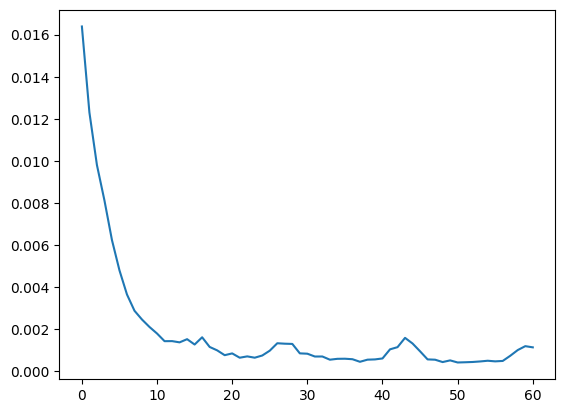

In [15]:
plt.plot(loss_list)

In [16]:
save_and_load(model, 'model/Infected/RNN.pth')

In [17]:
label_y, predicted = predict_mto(model, df, x_ss, y_ms)

8691.915893554688


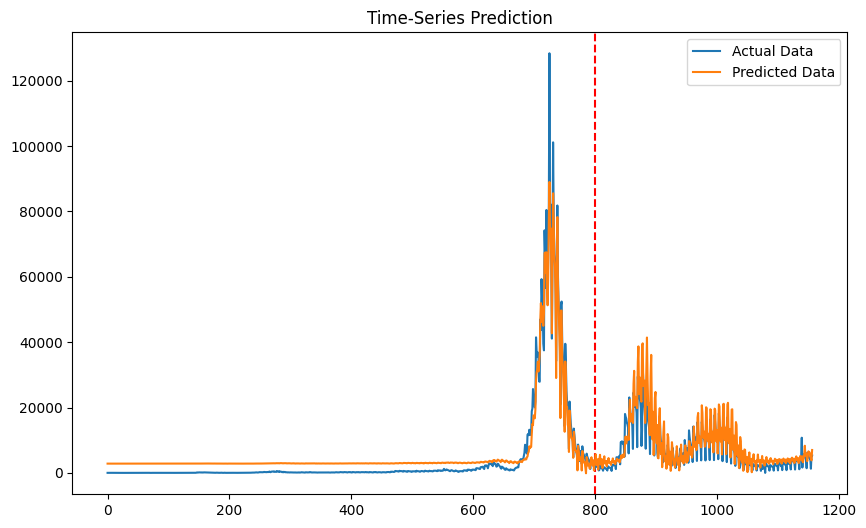

In [19]:
print(mape(label_y+1, predicted))
plotting(label_y, predicted, 800)

In [21]:
data_predicted = data.copy()
data_predicted['predicted_alpha'] = 0
data_predicted.iloc[62:, -1] = predicted
#data_predicted.iloc[63:, -1] = predicted

data_predicted['predicted_Infected'] = data_predicted['Infected']
for i in range(801, len(data_predicted)):
    data_predicted.iloc[i, -1] = (data_predicted.iloc[i-1, -1]
                                  *(1-data_predicted.iloc[i-1, 7] - data_predicted.iloc[i-1, 8]
                                    +(data_predicted.iloc[i-1, 2]*data_predicted.iloc[i-1, 9]
                                      /data_predicted.iloc[0, 2])))
data_predicted

KeyError: 'Infected'

In [22]:
plotting(data_predicted['Infected'], data_predicted['predicted_Infected'])

KeyError: 'Infected'

In [11]:
#path = 'Data/SIR_Origin/*.csv'
#dic_files = Load_files.load_files(path, -17, -15)
path = 'Data/Cleaned_deathCnt/*.csv'
dic_files = Load_files.load_files(path, -14, -12)
data = dic_files['서울']
data['dailyCnt'] = data['defCnt'].diff().fillna(0)
data

,deathCnt,defCnt,gubun,gubunEn,incDec,isolClearCnt,isolIngCnt,localOccCnt,overFlowCnt,qurRate,stdDay,dailyCnt
0,0,0,서울,Seoul,0.0,0,0,0,0,0.0,2020-01-20,0.0
1,0,0,서울,Seoul,0.0,0,0,0,0,0.0,2020-01-21,0.0
2,0,0,서울,Seoul,0.0,0,0,0,0,0.0,2020-01-22,0.0
3,0,0,서울,Seoul,0.0,0,0,0,0,0.0,2020-01-23,0.0
4,0,1,서울,Seoul,1.0,0,1,0,1,0.0,2020-01-24,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1214,6471,6162486,서울,Seoul,4329.0,0,0,4371,0,65361.0,2023-05-20,4329.0
1215,6473,6166682,서울,Seoul,4196.0,0,0,4195,1,65406.0,2023-05-21,4196.0
1216,6476,6167953,서울,Seoul,1271.0,0,0,1271,0,65419.0,2023-05-22,1271.0
1217,6477,6173315,서울,Seoul,5362.0,0,0,5359,3,65476.0,2023-05-23,5362.0


In [12]:
criterion = nn.MSELoss()
lr = 1e-4
patience = 20
hidden_size = 16
num_layers = 2
batch_size = 32
dropout = 0.25

input_size = 3
sequence_length = 60
num_epochs = 10000

#df = Prepare_df.processing(data, 'Date', 'alpha')
df = Prepare_df.processing(data, 'stdDay', 'dailyCnt')

x = df.iloc[:, 0:]
y = df.iloc[:,:1]

ms = MinMaxScaler()
ss = StandardScaler()

ss.fit(x)
ms.fit(y)

x, y, x_ss, y_ms, train_loader, test_loader = Prepare_df.split_data(df, 800, 60, 1, batch_size, 'mto')

model_RNN = RNN(input_size = input_size,
                hidden_size = hidden_size,
                sequence_length = sequence_length,
                num_layers = num_layers, 
                dropout = dropout, 
                device = device).to(device)

model = model_RNN

optimizer = Adam(model.parameters(), lr = lr)

torch.Size([800, 60, 3])
torch.Size([800, 1])
torch.Size([357, 60, 3])
torch.Size([357, 1])


In [13]:
df

,AC,DAC,DDAC
Date,,,
2020-01-22,0.0,0.0,0.0
2020-01-23,0.0,0.0,0.0
2020-01-24,1.0,1.0,1.0
2020-01-25,0.0,-1.0,-2.0
2020-01-26,0.0,0.0,1.0
...,...,...,...
2023-05-20,4329.0,-305.0,122.0
2023-05-21,4196.0,-133.0,172.0
2023-05-22,1271.0,-2925.0,-2792.0


In [14]:
loss_list, model = Trainer.Many_to_One(train_loader, 
                                       test_loader, 
                                       model, 
                                       criterion, 
                                       optimizer, 
                                       num_epochs, 
                                       patience,
                                       device)


 Early Stopping / epoch: 61 loss: 0.0011


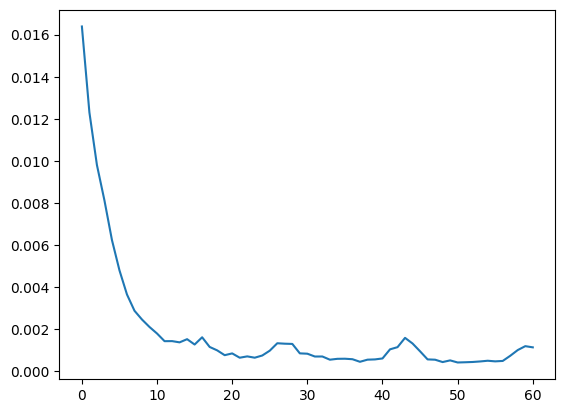

In [15]:
plt.plot(loss_list)

In [16]:
save_and_load(model, 'model/Infected/RNN.pth')

In [17]:
label_y, predicted = predict_mto(model, df, x_ss, y_ms)

8691.915893554688


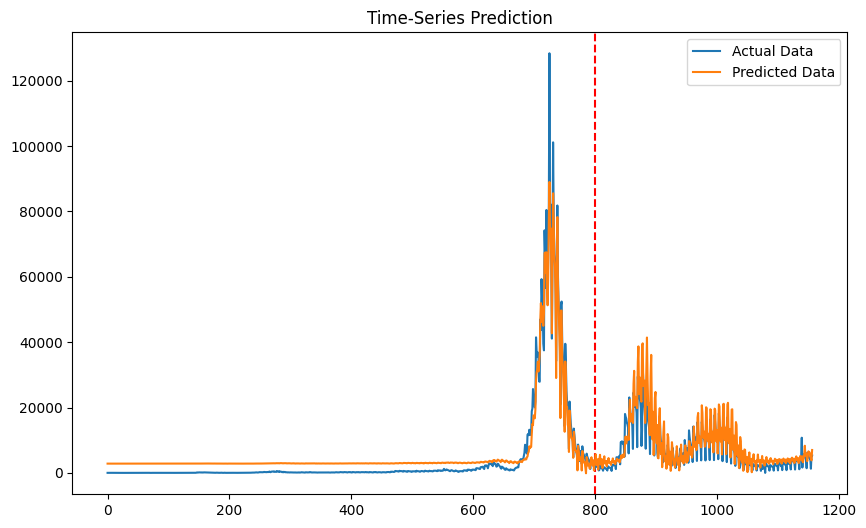

In [19]:
print(mape(label_y+1, predicted))
plotting(label_y, predicted, 800)

In [21]:
data_predicted = data.copy()
data_predicted['predicted_alpha'] = 0
data_predicted.iloc[62:, -1] = predicted
#data_predicted.iloc[63:, -1] = predicted

data_predicted['predicted_Infected'] = data_predicted['Infected']
for i in range(801, len(data_predicted)):
    data_predicted.iloc[i, -1] = (data_predicted.iloc[i-1, -1]
                                  *(1-data_predicted.iloc[i-1, 7] - data_predicted.iloc[i-1, 8]
                                    +(data_predicted.iloc[i-1, 2]*data_predicted.iloc[i-1, 9]
                                      /data_predicted.iloc[0, 2])))
data_predicted

KeyError: 'Infected'

In [22]:
plotting(data_predicted['Infected'], data_predicted['predicted_Infected'])

KeyError: 'Infected'